In [1]:
################ Higher moments global #################

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [2]:
LAT        = 50.42
LON        = 228.8
savefigs   = '/global/scratch/users/harsha/savefigs/Nov15/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
temp_path  = '/global/scratch/users/harsha/LENS/cesm2/cvals/global/temps/'
qpath      = '/global/scratch/users/harsha/LENS/cesm2/cvals/global/quantiles/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/global/rmse/'
cvals_us   = '/global/scratch/users/harsha/LENS/cesm2/cvals/conus/'
loc        = 'columbia'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
mae_path   = '/global/scratch/users/harsha/LENS/cesm2/cvals/global/mae/'

In [3]:
#CONUS lat-lon
top = 49.3457868 # north lat
left = -124.7844079+360 # west long
right = -66.9513812+360 # east long
bottom =  24.7433195 # south lat

In [4]:
#job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="lr6", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(15)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40573 instead
  warnings.warn(


In [5]:
pi_yr0  = '1900'
pi_yr1  = '1930'
#### Hist period ###
ht1_yr0 = '1950'
ht1_yr1 = '1980'
ht2_yr0 = '1980'
ht2_yr1 = '2010'
### Increased Carbon ###
ic1_yr0 = '2020'
ic1_yr1 = '2050'
ic2_yr0 = '2070'
ic2_yr1 = '2100'
doy     = 1 # day_of_year
date    = 'Jan1'

In [6]:
cluster

In [7]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 661 ms, sys: 83.1 ms, total: 744 ms
Wall time: 779 ms


In [8]:
%%time
#t-temp, nw - no-warming, w-warming, h= hist, 1 and 2 are periods.
th1g = ds_hist.TREFHTMX.sel(time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(ht1_yr0,ht1_yr1))
th2g = ds_hist.TREFHTMX.sel(time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(ht2_yr0,ht2_yr1))
tnwg = ds_hist.TREFHTMX.sel(time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_yr0,pi_yr1))

##### Warming ####
tw1g = ds_ssp.TREFHTMX.sel(time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic1_yr0,ic1_yr1))
tw2g = ds_ssp.TREFHTMX.sel(time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic2_yr0,ic2_yr1))

CPU times: user 635 ms, sys: 26.3 ms, total: 662 ms
Wall time: 651 ms


In [ ]:
#th2g

In [9]:
%%time
#g = global, u = us , h = hist, w =warming
tgnw = tnwg.stack(mtime=('member','time'),create_index=False)
############# Hist ###########
tgh1 = th1g.stack(mtime=('member','time'),create_index=False)
tgh2 = th2g.stack(mtime=('member','time'),create_index=False)
############## Warming #########
tgw1 = tw1g.stack(mtime=('member','time'),create_index=False)
tgw2 = tw2g.stack(mtime=('member','time'),create_index=False)
#twj30.mean().values - tnwj30.mean().values 
#tdw.std().values 

CPU times: user 31.4 ms, sys: 1.17 ms, total: 32.6 ms
Wall time: 30.8 ms


In [10]:
%%time
##########hc = historical corrected
tghc1 = (tgh1 - tgh1.mean('mtime'))*(tgnw.std('mtime')/tgh1.std('mtime')) \
+ tgnw.mean('mtime')
tghc2 = (tgh2 - tgh2.mean('mtime'))*(tgnw.std('mtime')/tgh2.std('mtime')) \
+ tgnw.mean('mtime')
########gw = global warming (ssp370)
tgwc1 = (tgw1 - tgw1.mean('mtime'))*(tgnw.std('mtime')/tgw1.std('mtime')) \
+ tgnw.mean('mtime')
tgwc2 = (tgw2 - tgw2.mean('mtime'))*(tgnw.std('mtime')/tgw2.std('mtime')) \
+ tgnw.mean('mtime')

CPU times: user 108 ms, sys: 10.9 ms, total: 119 ms
Wall time: 116 ms


In [12]:
%%time
##########hc = historical, m= mean only 
tghmc1 = (tgh1 - tgh1.mean('mtime')) + tgnw.mean('mtime')
tghmc2 = (tgh2 - tgh2.mean('mtime')) + tgnw.mean('mtime')
########gw = global warming (ssp370)
tgwmc1 = (tgw1 - tgw1.mean('mtime'))+ tgnw.mean('mtime')
tgwmc2 = (tgw2 - tgw2.mean('mtime'))+ tgnw.mean('mtime')

CPU times: user 66.2 ms, sys: 3.23 ms, total: 69.5 ms
Wall time: 66.6 ms


In [14]:
tgwmc2

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<add, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 2070-01-01 00:00:00 ... 2100-01-01 00:00:00
Dimensions without coordinates: mtime

In [15]:
# Set paths for local tmax - warming, no warming and corrected.
gnw_path   = temp_path+'tnw'  +date+'_'+pi_yr0  +'_' +pi_yr1  +'_global.zarr'
gh1_path   = temp_path+'thist'+date+'_'+ht1_yr0 +'_' +ht1_yr1 +'_global.zarr'
gh2_path   = temp_path+'thist'+date+'_'+ht2_yr0 +'_' +ht2_yr1 +'_global.zarr'
gw1_path   = temp_path+'tw'   +date+'_'+ic1_yr0 +'_' +ic1_yr1 +'_global.zarr'
gw2_path   = temp_path+'tw'   +date+'_'+ic2_yr0 +'_' +ic2_yr1 +'_global.zarr'
## Corrected paths 
ghc1_path  = temp_path+'thc'  +date+'_'+ht1_yr0+'_'+ht1_yr1 +'_global.zarr'
ghc2_path  = temp_path+'thc'  +date+'_'+ht2_yr0+'_'+ht2_yr1 +'_global.zarr'
gwc1_path  = temp_path+'twc'  +date+'_'+ic1_yr0+'_'+ic1_yr1 +'_global.zarr'
gwc2_path  = temp_path+'twc'  +date+'_'+ic2_yr0+'_'+ic2_yr1 +'_global.zarr'
## Mean- only ########
ghmc1_path  = temp_path+'thmc'  +date+'_'+ht1_yr0+'_'+ht1_yr1 +'_global.zarr'
ghmc2_path  = temp_path+'thmc'  +date+'_'+ht2_yr0+'_'+ht2_yr1 +'_global.zarr'
gwmc1_path  = temp_path+'twmc'  +date+'_'+ic1_yr0+'_'+ic1_yr1 +'_global.zarr'
gwmc2_path  = temp_path+'twmc'  +date+'_'+ic2_yr0+'_'+ic2_yr1 +'_global.zarr'

In [14]:
gnw_path

'/global/scratch/users/harsha/LENS/cesm2/cvals/global/temps/tnwJan1_1900_1930_global.zarr'

In [20]:
# %%time
# # Save daily,global tmax
# tgnw.to_dataset().to_zarr(gnw_path,mode='w')
# tgh1.to_dataset().to_zarr(gh1_path,mode='w')
# tgh2.to_dataset().to_zarr(gh2_path,mode='w')
# tgw1.to_dataset().to_zarr(gw1_path,mode='w')
# tgw2.to_dataset().to_zarr(gw2_path,mode='w')
# ####### Corrected paths ########
# tghc1.to_dataset().to_zarr(ghc1_path,mode='w')
# tghc2.to_dataset().to_zarr(ghc2_path,mode='w')
# tgwc1.to_dataset().to_zarr(gwc1_path,mode='w')
# tgwc2.to_dataset().to_zarr(gwc2_path,mode='w')
########Mean only ##################
tghmc1.to_dataset().to_zarr(ghmc1_path,mode='w')
tghmc2.to_dataset().to_zarr(ghmc2_path,mode='w')
tgwmc1.to_dataset().to_zarr(gwmc1_path,mode='w')
tgwmc2.to_dataset().to_zarr(gwmc2_path,mode='w')

In [16]:
%%time
tgnw  = xr.open_mfdataset(gnw_path,engine='zarr')
tgh1  = xr.open_mfdataset(gh1_path,engine='zarr')
tgh2  = xr.open_mfdataset(gh2_path,engine='zarr')
tgw1  = xr.open_mfdataset(gw1_path,engine='zarr')
tgw2  = xr.open_mfdataset(gw2_path,engine='zarr')
########## Corrected datasets ######
tghc1 = xr.open_mfdataset(ghc1_path,engine='zarr')
tghc2 = xr.open_mfdataset(ghc2_path,engine='zarr')
tgwc1 = xr.open_mfdataset(gwc1_path,engine='zarr')
tgwc2 = xr.open_mfdataset(gwc2_path,engine='zarr')
########## Corr: Mean only ############
tghmc1 = xr.open_mfdataset(ghc1_path,engine='zarr')
tghmc2 = xr.open_mfdataset(ghc2_path,engine='zarr')
tgwmc1 = xr.open_mfdataset(gwc1_path,engine='zarr')
tgwmc2 = xr.open_mfdataset(gwc2_path,engine='zarr')
########################################
tgnw   = tgnw.TREFHTMX
tgh1   = tgh1.TREFHTMX
tgh2   = tgh2.TREFHTMX
tgw1   = tgw1.TREFHTMX
tgw2   = tgw2.TREFHTMX
#############
tghc1  = tghc1.TREFHTMX
tghc2  = tghc2.TREFHTMX
tgwc1  = tgwc1.TREFHTMX
tgwc2  = tgwc2.TREFHTMX
#########################
tghmc1  = tghmc1.TREFHTMX
tghmc2  = tghmc2.TREFHTMX
tgwmc1  = tgwmc1.TREFHTMX
tgwmc2  = tgwmc2.TREFHTMX

CPU times: user 443 ms, sys: 43.2 ms, total: 486 ms
Wall time: 1.95 s


In [17]:
tgwmc1

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<open_dataset-c7da55fd62144d98c050f137ad5bfe0eTREFHTMX, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime

In [18]:
%%time
quants  = np.arange(0,1,0.001)
qgh1    = tgh1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgh2    = tgh2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgw1    = tgw1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgw2    = tgw2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgnw    = tgnw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
#######################
qgwc1   = tgwc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwc2   = tgwc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qghc1   = tghc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qghc2   = tghc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
###########################
qgwmc1   = tgwmc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwmc2   = tgwmc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qghmc1   = tghmc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qghmc2   = tghmc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
##### Warming anomalies ####
qgwa1   = qgw1-qgnw
qgwa2   = qgw2-qgnw
qgha1   = qgh1-qgnw
qgha2   = qgh2-qgnw
#######Corrected Anomalies ##########
qghca1  = qghc1-qgnw
qghca2  = qghc2-qgnw
qgwca1  = qgwc1-qgnw
qgwca2  = qgwc2-qgnw
####### Mean-only Corrected Anomalies ##########
qghmca1  = qghmc1-qgnw
qghmca2  = qghmc2-qgnw
qgwmca1  = qgwmc1-qgnw
qgwmca2  = qgwmc2-qgnw
######################
qgwca1  = qgwca1.rename({'quantile':'permilles'})
qgwca2  = qgwca2.rename({'quantile':'permilles'})
qghca1  = qghca1.rename({'quantile':'permilles'})
qghca2  = qghca2.rename({'quantile':'permilles'})
qgnw    = qgnw.rename({'quantile':'permilles'}) 
qgwmca1  = qgwmca1.rename({'quantile':'permilles'})
qgwmca2  = qgwmca2.rename({'quantile':'permilles'})
qghmca1  = qghmca1.rename({'quantile':'permilles'})
qghmca2  = qghmca2.rename({'quantile':'permilles'})
#############################


CPU times: user 374 ms, sys: 11 ms, total: 385 ms
Wall time: 377 ms


In [19]:
#Quantile Anomaly Paths - Global
qgha1_path    = qpath+'qgha'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
qgha2_path    = qpath+'qgha'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
qgwa1_path    = qpath+'qgwa'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
qgwa2_path    = qpath+'qgwa'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'
#######################################
qghca1_path   = qpath+'qghca'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
qghca2_path   = qpath+'qghca'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
qgwca1_path   = qpath+'qgwca'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
qgwca2_path   = qpath+'qgwca'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'
qgnw_path     = qpath+'qnw'+date+'_'+pi_yr0+'_'+pi_yr1+'.zarr'
#########################################
qghmca1_path   = qpath+'qghmca'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
qghmca2_path   = qpath+'qghmca'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
qgwmca1_path   = qpath+'qgwmca'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
qgwmca2_path   = qpath+'qgwmca'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'

<xarray.Dataset>
Dimensions:   (quantile: 1000, lat: 192, lon: 288)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * quantile  (quantile) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
Data variables:
    TREFHTMX  (quantile, lat, lon) float64 dask.array<chunksize=(1000, 192, 288), meta=np.ndarray>

In [22]:
%%time
##### Save quantile anomaly-Global #########
qgha1.to_dataset().to_zarr(qgha1_path,mode='w')
qgha2.to_dataset().to_zarr(qgha2_path,mode='w')
qgwa1.to_dataset().to_zarr(qgwa1_path,mode='w')
qgwa2.to_dataset().to_zarr(qgwa2_path,mode='w')
qgnw.to_dataset().to_zarr(qgnw_path,mode='w')

AttributeError: 'Dataset' object has no attribute 'to_dataset'

In [ ]:
%%time
###### Corrected quantiles ########
qghca1.to_dataset().to_zarr(qghca1_path,mode='w')
qghca2.to_dataset().to_zarr(qghca2_path,mode='w')
qgwca1.to_dataset().to_zarr(qgwca1_path,mode='w')
qgwca2.to_dataset().to_zarr(qgwca2_path,mode='w')

In [ ]:
%%time
###### (Mean-only) Corrected quantiles ########
qghmca1.to_dataset().to_zarr(qghmca1_path,mode='w')
qghmca2.to_dataset().to_zarr(qghmca2_path,mode='w')
qgwmca1.to_dataset().to_zarr(qgwmca1_path,mode='w')
qgwmca2.to_dataset().to_zarr(qgwmca2_path,mode='w')

In [21]:
%%time
############################
qgha1  = xr.open_mfdataset(qgha1_path,engine='zarr')
qgha2  = xr.open_mfdataset(qgha2_path,engine='zarr')
qgwa1  = xr.open_mfdataset(qgwa1_path,engine='zarr')
qgwa2  = xr.open_mfdataset(qgwa2_path,engine='zarr')
################################
qghca1 = xr.open_mfdataset(qghca1_path,engine='zarr')
qghca2 = xr.open_mfdataset(qghca2_path,engine='zarr')
qgwca1 = xr.open_mfdataset(qgwca1_path,engine='zarr')
qgwca2 = xr.open_mfdataset(qgwca2_path,engine='zarr')
qgnw   = xr.open_mfdataset(qgnw_path,engine='zarr')
#################################
qgwa1  = qgwa1.TREFHTMX
qgwa2  = qgwa2.TREFHTMX
qgha1  = qgha1.TREFHTMX
qgha2  = qgha2.TREFHTMX
qgnw   = qgnw.TREFHTMX
#########################
qghca1  = qghca1.TREFHTMX
qghca2  = qghca2.TREFHTMX
qgwca1  = qgwca1.TREFHTMX
qgwca2  = qgwca2.TREFHTMX
###########################

OSError: no files to open

In [ ]:
qgha1  = qgha1.rename({'quantile':'permilles'})
qgha2  = qgha2.rename({'quantile':'permilles'})
qgwa1  = qgwa1.rename({'quantile':'permilles'})
qgwa2  = qgwa2.rename({'quantile':'permilles'})

In [ ]:
qgwa2

In [ ]:
#Create Zero dataarray for true value (tv)
lats      = qgnw['lat'].data
lons      = qgnw['lon'].data
temp      = np.zeros((1000,lats.size,lons.size,))
permilles = qgnw['permilles'].data
#########################
tv = xr.DataArray(
    data=temp,
    dims=['permilles','lat', "lon"],
    coords=dict(
        lat     =(["lat"], lats),
        lon      =(["lon"], lons),
        permilles =(['permilles'],permilles),
    ),
    attrs=dict(
        description="2m air temperature.",
        units="degK",
    ),
)
####################
tv = tv.chunk(dict(permilles=1000,lat=1,lon=288))

In [ ]:
tv

In [ ]:
%%time
rmse_qgha1 = xs.rmse(qgha1,tv,dim='permilles')
rmse_qgha2 = xs.rmse(qgha2,tv,dim='permilles')
rmse_qgwa1 = xs.rmse(qgwa1,tv,dim='permilles')
rmse_qgwa2 = xs.rmse(qgwa2,tv,dim='permilles')
########################################
rmse_qghca1 = xs.rmse(qghca1,tv,dim='permilles')
rmse_qghca2 = xs.rmse(qghca2,tv,dim='permilles')
rmse_qgwca1 = xs.rmse(qgwca1,tv,dim='permilles')
rmse_qgwca2 = xs.rmse(qgwca2,tv,dim='permilles') 

In [ ]:
rmse_qgha1 = rmse_qgha1.rename('rmse_histano1')
rmse_qgha2 = rmse_qgha2.rename('rmse_histano2')
rmse_qgwa1 = rmse_qgwa1.rename('rmse_warmano1')
rmse_qgwa2 = rmse_qgwa2.rename('rmse_warmano2')
################################################
rmse_qghca1 = rmse_qghca1.rename('rmse_histCorrano1')
rmse_qghca2 = rmse_qghca2.rename('rmse_histCorrano2')
rmse_qgwca1 = rmse_qgwca1.rename('rmse_warmCorrano1')
rmse_qgwca2 = rmse_qgwca2.rename('rmse_warmCorrano2')

In [ ]:
rgha1_path    = cvals+'rmse_qgha'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
rgha2_path    = cvals+'rmse_qgha'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
rgwa1_path    = cvals+'rmse_qgwa'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
rgwa2_path    = cvals+'rmse_qgwa'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'
#######################################
rghca1_path   = cvals+'rmse_qghca'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
rghca2_path   = cvals+'rmse_qghca'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
rgwca1_path   = cvals+'rmse_qgwca'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
rgwca2_path   = cvals+'rmse_qgwca'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'
rgnw_path     = cvals+'rmse_qnw'+date+'_'+pi_yr0+'_'+pi_yr1+'.zarr' 

In [ ]:
%%time
##### Save RMSEs #######
rmse_qgha1.to_dataset().to_zarr(rgha1_path,mode='w')
rmse_qgha2.to_dataset().to_zarr(rgha2_path,mode='w')
rmse_qgwa1.to_dataset().to_zarr(rgwa1_path,mode='w')
rmse_qgwa2.to_dataset().to_zarr(rgwa2_path,mode='w')

In [ ]:
%%time
rmse_qghca1.to_dataset().to_zarr(rghca1_path,mode='w')
rmse_qghca2.to_dataset().to_zarr(rghca2_path,mode='w')
rmse_qgwca1.to_dataset().to_zarr(rgwca1_path,mode='w')
rmse_qgwca2.to_dataset().to_zarr(rgwca2_path,mode='w')

In [ ]:
%%time
rmse_qgha1 = xr.open_zarr(rgha1_path)
rmse_qgha1 = rmse_qgha1.rmse_histano1
rmse_qgha2 = xr.open_zarr(rgha2_path)
rmse_qgha2 = rmse_qgha2.rmse_histano2
rmse_qgwa1 = xr.open_zarr(rgwa1_path)
rmse_qgwa1 = rmse_qgwa1.rmse_warmano1
rmse_qgwa2 = xr.open_zarr(rgwa2_path)
rmse_qgwa2 = rmse_qgwa2.rmse_warmano2
#########################
rmse_qghca1 = xr.open_zarr(rghca1_path)
rmse_qghca1 = rmse_qghca1.rmse_histCorrano1
rmse_qghca2 = xr.open_zarr(rghca2_path)
rmse_qghca2 = rmse_qghca2.rmse_histCorrano2

rmse_qgwca1 = xr.open_zarr(rgwca1_path)
rmse_qgwca1 = rmse_qgwca1.rmse_warmCorrano1
rmse_qgwca2 = xr.open_zarr(rgwca2_path)
rmse_qgwca2 = rmse_qgwca2.rmse_warmCorrano2

In [ ]:
%%time
rmse_hfrac1 = (rmse_qgha1 - rmse_qghca1)/rmse_qgha1
rmse_hfrac2 = (rmse_qgha2 - rmse_qghca2)/rmse_qgha2
rmse_wfrac1 = (rmse_qgwa1 - rmse_qgwca1)/rmse_qgwa1
rmse_wfrac2 = (rmse_qgwa2 - rmse_qgwca2)/rmse_qgwa2

In [36]:
rmse_hfrac1

<xarray.DataArray (lat: 192, lon: 288)>
dask.array<truediv, shape=(192, 288), dtype=float64, chunksize=(1, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [37]:
%%time
rmse_lesswfrac2 = xr.where(rmse_wfrac2 < 0.75,rmse_wfrac2,1)
rmse_minwfrac2  = rmse_wfrac2.where(rmse_wfrac2==rmse_wfrac2.min(),drop=True)
rmse_lesswfrac2

CPU times: user 5min 21s, sys: 13.4 s, total: 5min 34s
Wall time: 5min 40s


<xarray.DataArray (lat: 192, lon: 288)>
dask.array<where, shape=(192, 288), dtype=float64, chunksize=(1, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [ ]:
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs    = np.arange(0,1,0.1)
rmse_hfrac2.plot.contourf(ax=ax,cmap='gist_ncar',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('RMSE signal for '+ date+ ' anomaly :'+str(ic1_yr0)+'-'+str(ic1_yr1))
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

In [40]:
#rmse_minfrac.values

In [44]:
#rmse_frac.sel(lat=56.07,lon=347.5,method='nearest').values

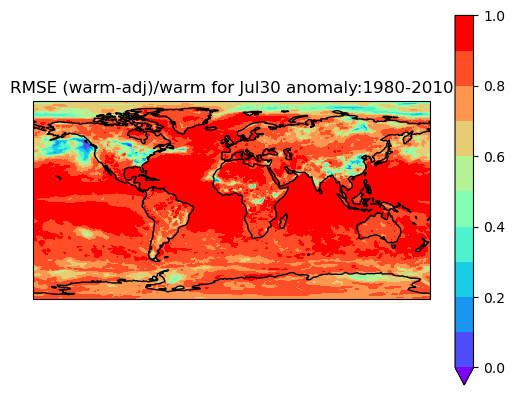

CPU times: user 1min 59s, sys: 27.7 s, total: 2min 27s
Wall time: 1min 58s


In [42]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs    = np.arange(0,1.1,0.1)
rmse_hfrac2.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('RMSE (warm-adj)/warm for '+date+' anomaly:'+str(ht2_yr0)+'-'+str(ht2_yr1))
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

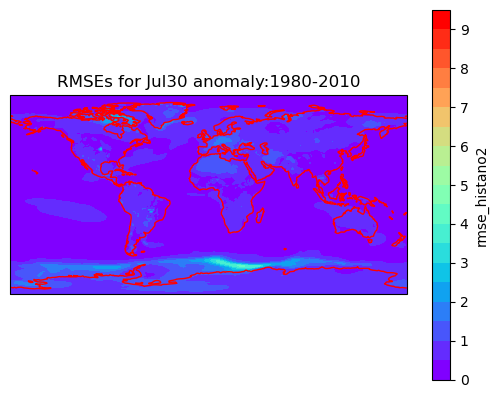

CPU times: user 25.1 s, sys: 2.98 s, total: 28.1 s
Wall time: 25.4 s


In [43]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,10,0.5)
rmse_qgha2.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('RMSEs for '+ date+' anomaly:'+str(ht2_yr0)+'-'+str(ht2_yr1))
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

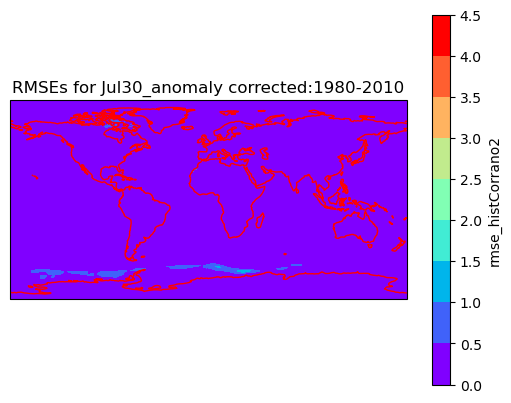

CPU times: user 14.1 s, sys: 1.04 s, total: 15.2 s
Wall time: 14.4 s


In [45]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,5,0.5)
rmse_qghca2.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('RMSEs for '+ date +'_anomaly corrected:'+str(ht2_yr0)+'-'+str(ht2_yr1))
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

In [ ]:
############## Mean Absolute Error #################

In [78]:
%%time
mae_qgha1 = xs.mae(qgha1,tv,dim='permilles')
mae_qgha2 = xs.mae(qgha2,tv,dim='permilles')
mae_qgwa1 = xs.mae(qgwa1,tv,dim='permilles')
mae_qgwa2 = xs.mae(qgwa2,tv,dim='permilles')
########################################
mae_qghca1 = xs.mae(qghca1,tv,dim='permilles')
mae_qghca2 = xs.mae(qghca2,tv,dim='permilles')
mae_qgwca1 = xs.mae(qgwca1,tv,dim='permilles')
mae_qgwca2 = xs.mae(qgwca2,tv,dim='permilles')

CPU times: user 880 ms, sys: 54.5 ms, total: 934 ms
Wall time: 887 ms


In [76]:
mgha1_path    = mae_path+'mae_qgha'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
mgha2_path    = mae_path+'mae_qgha'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
mgwa1_path    = mae_path+'mae_qgwa'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
mgwa2_path    = mae_path+'mae_qgwa'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'
#######################################
mghca1_path   = mae_path+'mae_qghca'+date+'_'+ht1_yr0+'_'+ht1_yr1+'.zarr'
mghca2_path   = mae_path+'mae_qghca'+date+'_'+ht2_yr0+'_'+ht2_yr1+'.zarr'
mgwca1_path   = mae_path+'mae_qgwca'+date+'_'+ic1_yr0+'_'+ic1_yr1+'.zarr'
mgwca2_path   = mae_path+'mae_qgwca'+date+'_'+ic2_yr0+'_'+ic2_yr1+'.zarr'
mgnw_path     = mae_path+'mae_qnw'  +date+'_'+pi_yr0+'_'+pi_yr1+'.zarr' 

In [77]:
mae_qgha1   = mae_qgha1.rename('mae_qgha1')
mae_qgha2   = mae_qgha2.rename('mae_qgha2')
mae_qgwa1   = mae_qgwa1.rename('mae_qgwa1')
mae_qgwa2   = mae_qgwa2.rename('mae_qgwa2')
##########################################
mae_qghca1   = mae_qghca1.rename('mae_qghca1')
mae_qghca2   = mae_qghca2.rename('mae_qghca2')
mae_qgwca1   = mae_qgwca1.rename('mae_qgwca1')
mae_qgwca2   = mae_qgwca2.rename('mae_qgwca2')

<xarray.DataArray 'mae_qgha1' (lat: 192, lon: 288)>
dask.array<transpose, shape=(192, 288), dtype=float64, chunksize=(1, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [81]:
%%time
mae_qgha1.to_dataset(name='mae_qgha1').to_zarr(mgha1_path,mode='w')
mae_qgha2.to_dataset(name='mae_qgha2').to_zarr(mgha2_path,mode='w')
mae_qgwa1.to_dataset(name='mae_qgwa1').to_zarr(mgwa1_path,mode='w')
mae_qgwa2.to_dataset(name='mae_qgwa2').to_zarr(mgwa2_path,mode='w')

CPU times: user 2min 29s, sys: 6.63 s, total: 2min 36s
Wall time: 2min 47s


In [57]:
# %%time
# ########################################
# mae_qghca1.to_dataset().to_zarr(mghca1_path,mode='w')
# mae_qghca2.to_dataset().to_zarr(mghca2_path,mode='w')
# mae_qgwca1.to_dataset().to_zarr(mgwca1_path,mode='w')
# mae_qgwca2.to_dataset().to_zarr(mgwca2_path,mode='w') 

In [87]:
%%time
mae_qgha1 = xr.open_zarr(mgha1_path)
mae_qgha2 = xr.open_zarr(mgha2_path,engine='zarr')
mae_qgwa1 = xr.open_zarr(mgwa1_path,engine='zarr')
mae_qgwa2 = xr.open_mfdataset(mgwa2_path,engine='zarr')
######################################
# mae_qghca1 = xr.open_mfdataset(mghca1_path,engine='zarr')
# mae_qghca2 = xr.open_mfdataset(mghca2_path,engine='zarr')
# mae_qgwca1 = xr.open_mfdataset(mgwca1_path,engine='zarr')
# mae_qgwca2 = xr.open_mfdataset(mgwca2_path,engine='zarr')
###############################
mae_qgha1   = mae_qgha1.mae_qgha1
# mae_qgha2   = mae_qgha2.rename('mae_qgha2')
# mae_qgwa1   = mae_qgwa1.rename('mae_qgwa1')
# mae_qgwa2   = mae_qgwa2.rename('mae_qgwa2')
# ##########################################
# mae_qghca1   = mae_qghca1.rename('mae_qghca1')
# mae_qghca2   = mae_qghca2.rename('mae_qghca2')
# mae_qgwca1   = mae_qgwca1.rename('mae_qgwca1')
# mae_qgwca2   = mae_qgwca2.rename('mae_qgwca2')
mae_qgha1

CPU times: user 466 ms, sys: 41.4 ms, total: 508 ms
Wall time: 478 ms


<xarray.DataArray 'mae_qgha1' (lat: 192, lon: 288)>
dask.array<open_dataset-24bd849b4cb3826b675bbca4083fbf63mae_qgha1, shape=(192, 288), dtype=float64, chunksize=(1, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [63]:
%%time
mae_hfrac1 = (mae_qgha1 - mae_qghca1)/mae_qgha1
mae_hfrac2 = (mae_qgha2 - mae_qghca2)/mae_qgha2
mae_wfrac1 = (mae_qgwa1 - mae_qgwca1)/mae_qgwa1
mae_wfrac2 = (mae_qgwa2 - mae_qgwca2)/mae_qgwa2

CPU times: user 129 ms, sys: 12.1 ms, total: 141 ms
Wall time: 130 ms


In [64]:
mae_wfrac1

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    *empty*

ValueError: at least one array or dtype is required

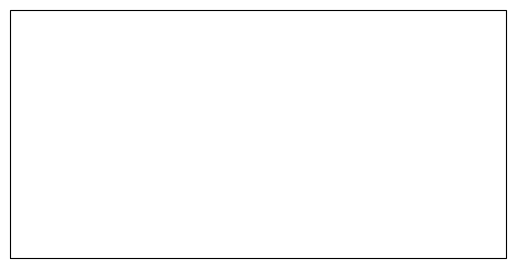

In [53]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,5,0.5)
mae_wfrac1.to_array().plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree())
ax.coastlines(color="red")
plt.title('MAE (1- warm/corr) for ' +date+ ' anomaly:'+str(ic1_yr0)+'-'+str(ic1_yr1))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

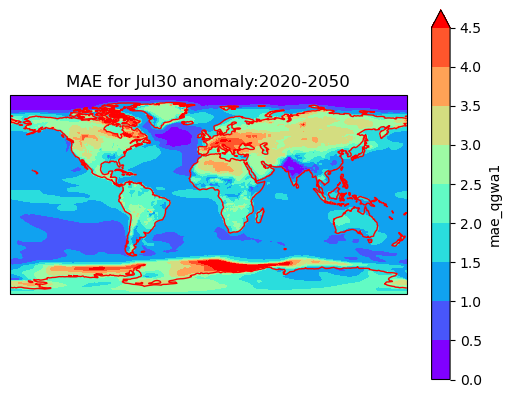

CPU times: user 33.5 s, sys: 5.01 s, total: 38.5 s
Wall time: 34.1 s


In [54]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,5,0.5)
mae_qgwa1.mae_qgwa1.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('MAE for ' +date+ ' anomaly:'+str(ic1_yr0)+'-'+str(ic1_yr1))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

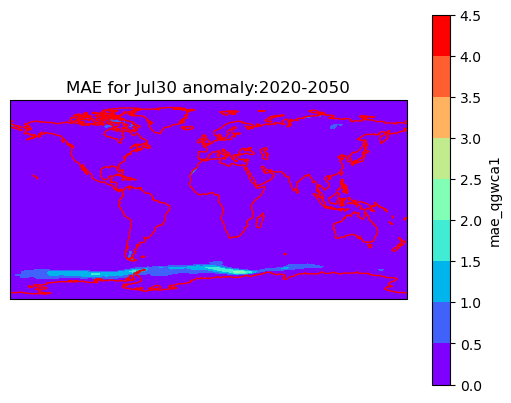

CPU times: user 15.8 s, sys: 1.17 s, total: 16.9 s
Wall time: 16.1 s


In [55]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,5,0.5)
mae_qgwca1.mae_qgwca1.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('MAE for '+date+' anomaly:'+str(ic1_yr0)+'-'+str(ic1_yr1))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

In [ ]:
dask.config.set({"array.slicing.split_large_chunks": True})  #Split large chunks

In [ ]:
%%time
######## Boostrap Confidence Intervals for the quantiles #####
#a = anopmaly, b=bootstrap samples
nboot   = 1000
tgnwb   = xs.resample_iterations(tgnw,nboot,'mtime')
tgwb    = xs.resample_iterations(tgw,nboot,'mtime')
tgcb    = xs.resample_iterations(tgc,nboot,'mtime')

In [ ]:
tgwb

In [ ]:
%%time
############ Global #################
quants  = np.arange(0,1,0.001)
qgnwb   = tgnwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwb    = tgwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgcb    = tgcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwab   = qgwb - qgnwb
qgcab   = qgcb - qgnwb

In [ ]:
qgwab 

In [ ]:
qgwb_path    = cvals+'qgwb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgnwb_path   = cvals+'qgnwb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgcb_path    = cvals+'qgcb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'

qgwab_path   = cvals+'qgwab'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgcab_path   = cvals+'qgcab'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'

In [ ]:
%%time
#qgwb      = qgwb.rename({'quantile':'permilles'})
#qgwb.to_dataset().to_zarr(qgwb_path,mode='w')

In [ ]:
%%time
qgwab      = qgwab.rename({'quantile':'permilles'})
qgcab      = qgcab.rename({'quantile':'permilles'})
#qgwab.to_dataset().to_zarr(qgwab_path,mode='w')
#qgcab.to_dataset().to_zarr(qgcab_path,mode='w')

In [ ]:
%%time
qgwab = xr.open_mfdataset(qgwab_path,engine='zarr')
qgcab = xr.open_mfdataset(qgcab_path,engine='zarr')

In [ ]:
%%time
qgwa_cilb = qgwab.chunk(dict(iteration=-1)).quantile(0.05,dim='iteration')
qgwa_ciub = qgwab.chunk(dict(iteration=-1)).quantile(0.95,dim='iteration')
qgca_cilb = qgcab.chunk(dict(iteration=-1)).quantile(0.05,dim='iteration')
qgca_ciub = qgcab.chunk(dict(iteration=-1)).quantile(0.95,dim='iteration')

In [ ]:
qgwa_cilbpath = cvals+'qgwa_cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgwa_ciubpath = cvals+'qgwa_ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgca_cilbpath = cvals+'qgca_cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgca_ciubpath = cvals+'qgca_ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgwa_cilbpath

In [ ]:
%%time
#qgwa_cilb.to_dataset().to_zarr(qgwa_cilbpath,mode='w')
#qgwa_ciub.to_dataset().to_zarr(qgwa_ciubpath,mode='w')
qgca_cilb.to_dataset().to_zarr(qgca_cilbpath,mode='w')
#quca_cilb.to_dataset().to_zarr(quca_cilbpath,mode='w')

In [ ]:
%%time
qgca_ciub.to_dataset().to_zarr(qgca_ciubpath,mode='w')

In [ ]:
%%time
#qgwa_cilb = xr.open_mfdataset(qgwa_cilbpath,engine='zarr')
#qgwa_ciub = xr.open_mfdataset(qgwa_ciubpath,engine='zarr')
qgca_cilb = xr.open_mfdataset(qgca_cilbpath,engine='zarr')
#qgca_ciub = xr.open_mfdataset(qgca_ciubpath,engine='zarr')
#qgwa_cilb = qgwa_cilb.TREFHTMX.drop('quantile')
#qgwa_ciub  = qgwa_ciub.TREFHTMX.drop('quantile')
qgca_cilb = qgca_cilb.TREFHTMX.drop('quantile')
#qgca_ciub = qgca_ciub.TREFHTMX.drop('quantile')

In [ ]:
qgca_ci = xr.concat([qgca_cilb,qgca_ciub],'permilles')
qgca_ci

In [ ]:
qgca_count = ((qgca_cilb > 0)).sum(axis=0)
qgca_count.where(qgca_count!=0).values